# Make some density shells

In [1]:
import numpy as np
from bnt_smooth import LognormalWeakLensingSim

In [2]:
# --- Define a parent n(z) and tomographic binning ---
def parent_nz(z):
    return z**2 * np.exp(-(z / 0.5)**1.5)

def make_equal_ngal_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    nz = nz_func(z)
    nz /= np.trapezoid(nz, z)
    cdf = np.cumsum(nz)
    cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate([[0], cdf, [1]]),
                       np.concatenate([[z[0]], z, [z[-1]]]))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i+1])
        bins.append((z[mask], nz[mask]))
    return bins, edges

# --- Simulation settings ---
z = np.linspace(0.01, 2.5, 500)
nz_list, _ = make_equal_ngal_bins(parent_nz, z, nbins=3)
n_eff_list = [30.0] * 3
sigma_eps_list = [0.26] * 3
baryon_feedback = 3.13
sigma8 = 0.8
seed = 1234
l_max = 1500
nside = 1024
lognormal_shift = 1.0
nslices = 5

# --- Initialize simulation ---
sim = LognormalWeakLensingSim(
    z_array = z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    sigma8=sigma8,
    lognormal_shift=lognormal_shift,
    seed=seed,
    l_max=l_max,
    nside= nside,
    nslices=nslices
)

sim.set_cosmo()

# --- Generate lognormal matter fields from scratch ---
maps = sim.generate_matter_fields_from_scratch()

# --- Print summary ---
print(f"Generated {len(maps)} lognormal HEALPix maps.")
print(f"Each map has {maps[0].size} pixels (nside = {sim.nside})")

print(sim.l_max)

Generated 5 lognormal HEALPix maps.
Each map has 12582912 pixels (nside = 1024)
1500


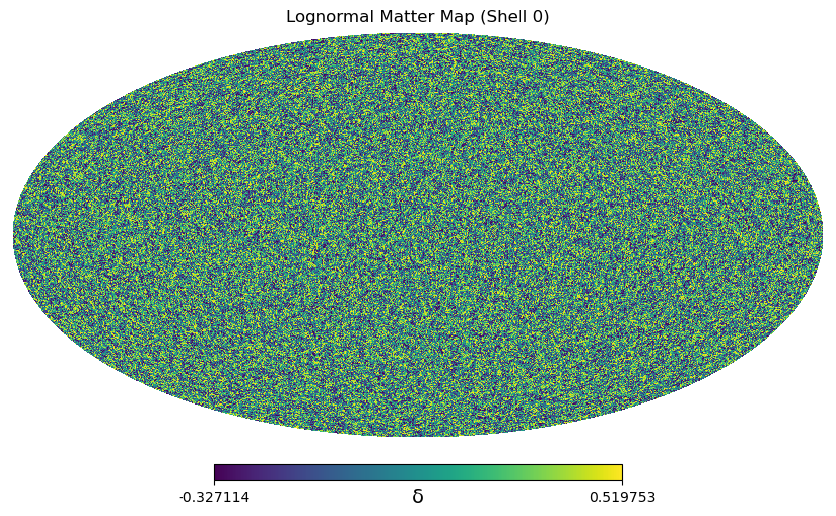

In [3]:
import healpy as hp
import matplotlib.pyplot as plt

# --- Plot the first map (shell 0) ---
hp.mollview(maps[4], title="Lognormal Matter Map (Shell 0)", unit="δ", norm='hist')
plt.show()


# Use these to compute kappa maps

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from bnt_smooth import LognormalWeakLensingSim

# --- Define parent n(z) and tomographic binning ---
def parent_nz(z):
    return z**2 * np.exp(-(z / 0.5)**1.5)

def make_equal_ngal_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    nz = nz_func(z)
    nz /= np.trapezoid(nz, z)
    cdf = np.cumsum(nz)
    cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate([[0], cdf, [1]]),
                       np.concatenate([[z[0]], z, [z[-1]]]))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i+1])
        bins.append((z[mask], nz[mask]))
    return bins, edges

# --- Simulation settings ---
z = np.linspace(0.01, 3., 500)
nz_list, _ = make_equal_ngal_bins(parent_nz, z, nbins=3)
n_eff_list = [30.0] * 3
sigma_eps_list = [0.26] * 3
baryon_feedback = 3.13
sigma8 = 0.8
seed = 10
l_max = 1024
nside = 1024
lognormal_shift = 1.0
nslices = 5

# --- Initialize simulation ---
sim = LognormalWeakLensingSim(
    z_array = z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    sigma8=sigma8,
    lognormal_shift=lognormal_shift,
    seed=seed,
    l_max=l_max,
    nside=nside,
    nslices=nslices
)

sim.set_cosmo()

# --- Step 1: Generate lognormal matter fields ---
matter_maps = sim.generate_matter_fields_from_scratch()
print(f"Generated {len(matter_maps)} lognormal matter maps.")

# --- Step 2: Compute kappa maps for each tomographic bin ---
kappa_maps = sim.compute_kappa_maps(matter_maps)
print(f"Computed {len(kappa_maps)} κ-maps (one per tomographic bin).")

# --- Step 3: Plot the first κ-map ---
hp.mollview(kappa_maps[0], title="Convergence κ Map (Tomo Bin 1)", unit="κ")
plt.show()

# Compute some data vectors and different responses

In [ ]:

import matplotlib.pyplot as plt

# --- Define shift values to compare ---
shifts = [0.9, 1.0, 1.1, ]
hist_data = []

for shift in shifts:
    print(f"Computing κ map with lognormal_shift = {shift}")
    
    # Set shift and regenerate matter maps
    sim.lognormal_shift = shift
    matter_maps = sim.generate_matter_fields_from_scratch()
    
    # Compute kappa maps
    kappa_maps = sim.compute_kappa_maps(matter_maps)
    
    # Take the first tomographic bin
    kappa_bin_0 = kappa_maps[0]
    hist_data.append(kappa_bin_0)

# --- Plot histograms ---
plt.figure(figsize=(8, 5))
bins = np.linspace(-0.01, 0.01, 100)  # Adjust range as needed

for i, kappa in enumerate(hist_data):
    print (np.mean(kappa))
    plt.hist(kappa, bins=bins, histtype='step', label=f'shift={shifts[i]}', density=True)

plt.xlabel("κ value")
plt.ylabel("Normalized count")
plt.title("κ Histogram (Tomographic Bin 1)")
plt.legend()
#plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()


# visualise what happens for different values of the baryonic feedback parameter

In [ ]:
import matplotlib.pyplot as plt

# --- Define baryonic feedback values to compare ---
feedback_values = [6.0,8.0]
hist_data = []

for feedback in feedback_values:
    print(f"Computing κ map with baryon_feedback = {feedback}")
    
    # Set feedback parameter and regenerate matter maps
    sim.baryon_feedback = feedback
    sim.set_cosmo()
    matter_maps = sim.generate_matter_fields_from_scratch()
    
    # Compute kappa maps
    kappa_maps = sim.compute_kappa_maps(matter_maps)
    
    # Take the first tomographic bin
    kappa_bin_0 = kappa_maps[0]
    hist_data.append(kappa_bin_0)

# --- Plot histograms ---
plt.figure(figsize=(8, 5))
bins = np.linspace(-0.01, 0.01, 100)  # Adjust as needed

for i, kappa in enumerate(hist_data):
    print(f"Mean κ for feedback={feedback_values[i]}: {np.mean(kappa):.4e}")
    plt.hist(kappa, bins=bins, histtype='step', label=f'feedback={feedback_values[i]}', density=True)

plt.xlabel("κ value")
plt.ylabel("Normalized count")
plt.title("κ Histogram (Tomographic Bin 1) vs Baryon Feedback")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
second_moments = [np.var(kappa) for kappa in hist_data]

In [ ]:
for feedback, var in zip(feedback_values, second_moments):
    print(f"Feedback {feedback}:  ⟨κ²⟩ = {var:.4e}")

In [ ]:
import healpy as hp

# --- Compute C_ell^{κκ} for both maps ---
cl_list = [hp.anafast(kappa, lmax=sim.l_max) for kappa in hist_data]
ell = np.arange(len(cl_list[0]))

# --- Plot ---
plt.figure(figsize=(8, 5))
for i, cl in enumerate(cl_list):
    plt.plot(ell, ell * (ell + 1) * cl / (2 * np.pi), label=f'feedback={feedback_values[i]}')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell^{\kappa\kappa}/2\pi$')
plt.title('κ Power Spectrum (Tomographic Bin 1)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# --- Define sigma8 values to compare ---
sigma8_values = [0.75, 0.8, 0.85]
hist_data = []

for s8 in sigma8_values:
    print(f"Computing κ map with sigma8 = {s8}")
    
    # Set sigma8 and regenerate cosmology and matter maps
    sim.sigma8 = s8
    sim.set_cosmo()
    matter_maps = sim.generate_matter_fields_from_scratch()
    
    # Compute kappa maps
    kappa_maps = sim.compute_kappa_maps(matter_maps)
    
    # Take the first tomographic bin
    kappa_bin_0 = kappa_maps[0]
    hist_data.append(kappa_bin_0)

# --- Plot histograms ---
plt.figure(figsize=(8, 5))
bins = np.linspace(-0.01, 0.01, 100)  # Adjust as needed

for i, kappa in enumerate(hist_data):
    print(f"Mean κ for sigma8={sigma8_values[i]}: {np.mean(kappa):.4e}")
    plt.hist(kappa, bins=bins, histtype='step', label=f'σ₈={sigma8_values[i]}', density=True)

plt.xlabel("κ value")
plt.ylabel("Normalized count")
plt.title("κ Histogram (Tomographic Bin 1) vs σ₈")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Make sure the noise is working

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from bnt_smooth import LognormalWeakLensingSim

# --- Define parent n(z) and tomographic binning ---
def parent_nz(z):
    return z**2 * np.exp(-(z / 0.5)**1.5)

def make_equal_ngal_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    nz = nz_func(z)
    nz /= np.trapezoid(nz, z)
    cdf = np.cumsum(nz)
    cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate([[0], cdf, [1]]),
                       np.concatenate([[z[0]], z, [z[-1]]]))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i+1])
        bins.append((z[mask], nz[mask]))
    return bins, edges

# --- Simulation settings ---
z = np.linspace(0.01, 3., 500)
nz_list, _ = make_equal_ngal_bins(parent_nz, z, nbins=3)
n_eff_list = [30.0] * 3
sigma_eps_list = [0.26] * 3
baryon_feedback = 3.13
sigma8 = 0.8
seed = 10
l_max = 1024
nside = nside
lognormal_shift = 1.0
nslices = 5

# --- Initialize simulation ---
sim = LognormalWeakLensingSim(
    z_array = z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    sigma8=sigma8,
    lognormal_shift=lognormal_shift,
    seed=seed,
    l_max=l_max,
    nside = nside,
    nslices=nslices
)

sim.set_cosmo()

# --- Step 1: Generate lognormal matter fields ---
matter_maps = sim.generate_matter_fields_from_scratch()
print(f"Generated {len(matter_maps)} lognormal matter maps.")

# --- Step 2: Compute kappa maps for each tomographic bin ---
kappa_maps = sim.compute_kappa_maps(matter_maps)
print(f"Computed {len(kappa_maps)} κ-maps (one per tomographic bin).")

# --- Step 3: Plot the first κ-map ---
hp.mollview(kappa_maps[0], title="Convergence κ Map (Tomo Bin 1)", unit="κ")
plt.show()



In [ ]:
# --- Step 4: Generate noise-only κ maps ---
noise_maps = sim.generate_noise_only_kappa_maps()
print(f"Generated {len(noise_maps)} noise-only κ-maps.")

# --- Step 5: Compute and plot power spectra for noise maps ---
lmax = sim.l_max
ell = np.arange(lmax + 1)

plt.figure(figsize=(8, 5))

for i, noise_map in enumerate(noise_maps):
    cl_noise = hp.anafast(noise_map, lmax=lmax)
    plt.plot(ell, cl_noise, label=f'Tomo Bin {i+1}')

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{\mathrm{noise}}$')
plt.title("Power Spectra of Noise-Only κ Maps")
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

# Let's start playing around with the BNT stuff

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from bnt_smooth import LognormalWeakLensingSim
from bnt_smooth import ProcessMaps

# --- Define parent n(z) and tomographic binning ---
def parent_nz(z):
    return z**2 * np.exp(-(z / 0.5)**1.5)

def make_equal_ngal_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    nz = nz_func(z)
    nz /= np.trapezoid(nz, z)
    cdf = np.cumsum(nz)
    cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate([[0], cdf, [1]]),
                       np.concatenate([[z[0]], z, [z[-1]]]))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i+1])
        bins.append((z[mask], nz[mask]))
    return bins, edges

# --- Simulation settings ---
z = np.linspace(0.01, 3., 500)
nz_list, _ = make_equal_ngal_bins(parent_nz, z, nbins=5)
n_eff_list = [30.0] * 5
sigma_eps_list = [0.26] * 5
baryon_feedback = 3.13
sigma8 = 0.8
seed = 10
l_max = 1024
nside = 1024
lognormal_shift = 1.0
nslices = 5

# --- Initialize simulation ---
sim = ProcessMaps(
    z_array = z,
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    sigma8=sigma8,
    lognormal_shift=lognormal_shift,
    seed=seed,
    l_max=l_max,
    nside=nside,
    nslices=nslices
)



In [ ]:
kappa_maps = sim.generate_noisy_kappa_maps()

In [ ]:
# test all the functions
sim.compute_moments(kappa_maps)
out = sim.get_bnt_matrix()

In [ ]:
bnt_kappa_maps = sim.bnt_transform_kappa_maps(kappa_maps)

In [ ]:
reversed_kappa_maps = sim.inverse_bnt_transform_kappa_maps(bnt_kappa_maps)

In [ ]:
import matplotlib.pyplot as plt

# --- Get chi and q(chi) for all source bins ---
chi, q_list = sim.get_lensing_kernels_on_z_grid()

# --- Plot ---
plt.figure(figsize=(8, 5))
for i, q in enumerate(q_list):
    plt.plot(chi, q, label=f'Bin {i+1}')

plt.xlabel(r'$\chi$ [Mpc]')
plt.ylabel(r'$q^i(\chi)$')
plt.title('Lensing Efficiency Kernels')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# --- Get χ and BNT-transformed kernels ---
q_bnt_list = sim.bnt_transform_lensing_kernels()

# --- Plot ---
plt.figure(figsize=(8, 5))
for i, q_bnt in enumerate(q_bnt_list):
    plt.plot(chi, q_bnt, label=f'BNT bin {i+1}')

plt.xlabel(r'$\chi$ [Mpc]')
plt.ylabel(r'$q^{\mathrm{BNT}}(\chi)$')
plt.title('BNT-Transformed Lensing Kernels')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
sim.compute_kernel_weighted_mean_chi(chi, q_list)

In [ ]:
sim.compute_kernel_weighted_mean_chi(chi, q_bnt_list)